In [1]:
import mesa
from mesa import Model, Agent
from mesa.datacollection import DataCollector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/Users/oyama-kenshin/Desktop/Vault/05_Codes/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Participants(Agent):
    def __init__(self, model):
        super().__init__(model)
        self.has_token = False

        # 資産と効用
        self.wealth = self.model.base_wealth + int(self.random.normalvariate(0, 20))
        self.wealth = max(0, self.wealth)
        # 価値観パラメータ (個性を決定)
        # W_i(1) (独占時の効用) > W_i(N) (飽和時の効用) の制約を満たすように生成
        self.w_1 = self.random.normalvariate(150, 20)
        self.w_n = self.w_1 * self.random.uniform(0.40, 0.60) 

        # 効用が負にならないように調整
        self.w_1 = max(0, self.w_1)
        self.w_n = max(0, self.w_n)

        # L_i(N-1) (最大疎外感)
        self.l_0 = 0
        self.l_n_minus_1 = -self.random.normalvariate(225, 40) # 疎外感が小さい
        if self.l_n_minus_1 > 0:
            self.l_n_minus_1 = -self.l_n_minus_1

        #print(f"ResearcherAgent {self.unique_id} initialized with wealth {self.wealth}, w_1 {self.w_1}, w_n {self.w_n}, l_n-1 {self.l_n_minus_1}")
    
    def calculate_bid(self, k, n):
        # W_k+1とL_kの計算
        w_k_plus_1 = self.w_1 - (self.w_1 - self.w_n) * (k / (n - 1))
        l_k = self.l_n_minus_1 * (k / (n - 1))

        #購入額の計算
        bid_price = w_k_plus_1 - l_k
        return bid_price

    def buy_if_interested(self, k):
        #k=self.model.sold_tokens
        n=self.model.num_agents

        if k >= self.model.num_data or self.has_token:
            return False

        #購入額の計算
        bid_price = self.calculate_bid(k, n)
        #print(f"Agent {self.unique_id} with wealth {self.wealth} bids {bid_price} when {k} tokens sold out of {n} participants.")
        
        if bid_price >= self.model.initial_price and self.model.initial_price <= self.wealth:
            # 購入
            self.wealth -= self.model.initial_price
            self.has_token = True
            self.model.sold_tokens += 1
            self.model.provider_revenue += self.model.initial_price
            #print(f"Agent {self.unique_id} bought a token")
            return True
        else:
            #print(f"Agent {self.unique_id} did not buy a token")
            return False

In [3]:
class DataMarket(Model):
    def __init__(self, num_agents, num_data, initial_price, base_wealth, seed=None):
        super().__init__(seed=seed)
        self.num_data = num_data
        self.initial_price = initial_price
        self.base_wealth = base_wealth
        self.num_agents = num_agents
         # エージェントの内訳を指定する辞書
        self.steps = 0

        #providerの設定
        self.provider_revenue = 0
        self.sold_tokens = 0

        self.datacollector = DataCollector(
            model_reporters={
                "Holders": lambda m: m.sold_tokens,
                "ProviderRevenue": "provider_revenue"
            }
        )
        self.datacollector.collect(self)

        # エージェントの生成
        self.participants = Participants.create_agents(self, n=num_agents)

    def step(self):
        k = self.sold_tokens
        self.participants.shuffle_do("buy_if_interested", k=k)

In [25]:
test_model = DataMarket(num_agents=1000, num_data=1000, initial_price = 190, base_wealth=550, seed=42)

for _ in range(50):
    test_model.step()
    test_model.datacollector.collect(test_model)
    print(f"Step {_+1} complete. Total sold tokens: {test_model.sold_tokens}, Provider revenue: {test_model.provider_revenue}")



Step 1 complete. Total sold tokens: 24, Provider revenue: 4560
Step 2 complete. Total sold tokens: 30, Provider revenue: 5700
Step 3 complete. Total sold tokens: 33, Provider revenue: 6270
Step 4 complete. Total sold tokens: 38, Provider revenue: 7220
Step 5 complete. Total sold tokens: 42, Provider revenue: 7980
Step 6 complete. Total sold tokens: 45, Provider revenue: 8550
Step 7 complete. Total sold tokens: 45, Provider revenue: 8550
Step 8 complete. Total sold tokens: 45, Provider revenue: 8550
Step 9 complete. Total sold tokens: 45, Provider revenue: 8550
Step 10 complete. Total sold tokens: 45, Provider revenue: 8550
Step 11 complete. Total sold tokens: 45, Provider revenue: 8550
Step 12 complete. Total sold tokens: 45, Provider revenue: 8550
Step 13 complete. Total sold tokens: 45, Provider revenue: 8550
Step 14 complete. Total sold tokens: 45, Provider revenue: 8550
Step 15 complete. Total sold tokens: 45, Provider revenue: 8550
Step 16 complete. Total sold tokens: 45, Provider

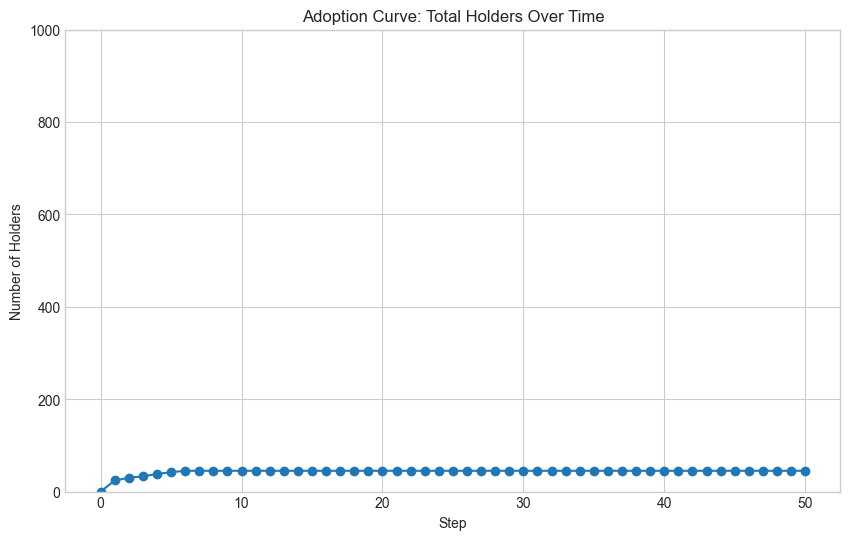

In [26]:
# Get the collected data from the model
results_df = test_model.datacollector.get_model_vars_dataframe()

# Plot the results
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))

# Plot the number of holders over time
plt.plot(results_df.index, results_df['Holders'], marker='o', linestyle='-')

plt.title('Adoption Curve: Total Holders Over Time')
plt.xlabel('Step')
plt.ylabel('Number of Holders')
plt.ylim(0, 1000)
plt.grid(True)
plt.show()